In [1]:
# !pip install pyspark==3.2.4

Make sure to install the same version of pyspark as your Apache spark installation.

In [186]:
print(f"PySpark version: {pyspark.__version__}")

PySpark version: 3.2.4


In [185]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns

#importing the packages
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation #for correlation matrix
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

**SparkContext** is the entry point to interact with Apache Spark. 
- Represents the connection to a spark Cluster
- It is used to create RDDs. (Resilient Distributed Datasets)

1. **master** parameter defines in which mode Spark should run, (in this case **local[2]**)
- **local** means, everything will be done locally in the system. 
- **2** means, it will have 2 worker threads so that tasks can be done parallely in 2 threads.

***However, it's important to note that the usage of SparkContext has been somewhat deprecated in favor of using SparkSession in more recent versions of PySpark. A SparkSession provides a higher-level API that encapsulates the functionality of both SparkContext and SQLContext, making it easier to work with Spark's different features.***

In [187]:
# sc = SparkContext(master='local[2]')
# #spark UI
# sc

In [188]:
spark = SparkSession.builder.appName("CustomerAnalysisSpark").getOrCreate()

In [189]:
spark

#### Workflow
- Data Prep
- Feature Engineering
- Model Building
- Evaluate

In [6]:
#loading our dataset
df = spark.read.csv("marketing_campaign1.csv", header = True, inferSchema = True)

In [7]:
#preview dataset
df.show(1)

+---+----+----------+----------+--------------+-------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|_c0|  ID|Year_Birth| Education|Marital_Status| Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+---+----+----------+----------+--------------+-------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-------------

In [8]:
#check for columns
print(df.columns)
print("\nTotal Columns: ",len(df.columns))

['_c0', 'ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

Total Columns:  30


In [9]:
df.count()

2240

#### Initially, the dataset has 2240 rows and 30 columns.

In [10]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integ

In [11]:
df.select('_c0').show(5)

+---+
|_c0|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



Dropping the c0 feature as it is just the index.

In [12]:
df = df.drop("_c0")
df.columns

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response']

In [13]:
df.select('Year_Birth').show(5)

+----------+
|Year_Birth|
+----------+
|      1957|
|      1954|
|      1965|
|      1984|
|      1981|
+----------+
only showing top 5 rows



### Dt_Customer feature is a date feature but has been assigned as a string. Changing it back to date feature.

In [14]:
# Convert the Dt_customer column to a date type
df = df.withColumn("DateJoined", to_date(col("Dt_Customer"), "dd-MM-yyyy"))

In [15]:
df = df.withColumn("YearJoined", year(col("DateJoined")))

In [16]:
df.select('YearJoined').show(5)

+----------+
|YearJoined|
+----------+
|      2012|
|      2014|
|      2013|
|      2014|
|      2014|
+----------+
only showing top 5 rows



Now as the **Dt_Customer** feature has been changed to **DateJoined** feature, the former can be dropped from the dataframe. 

(Only the name has been changed along with the datatype has been changed to date format)

In [17]:
df = df.drop("Dt_Customer")

In [18]:
print(df.columns)
len(df.columns)

['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'DateJoined', 'YearJoined']


30

### Taking a Look at the years the customers got engaged with the company

In [19]:
unique_custYear = df.groupBy('YearJoined').agg(count("YearJoined").alias("YearCount")).orderBy(col("YearJoined").asc())
unique_custYear.show()

+----------+---------+
|YearJoined|YearCount|
+----------+---------+
|      2012|      494|
|      2013|     1189|
|      2014|      557|
+----------+---------+



As it can bee seen the dataset contains information about only the years 2012, 2013 and 2014. So for ease, I have decided to calculate the age for the year ***2015***. 

### Adding Column 'DaysSinceJoined' using the 'DateJoined' Feature. 

In [20]:
reference_date = "2015-01-01"
reference_date_col = lit(reference_date).cast(DateType())

In [21]:
df = df.withColumn("DaysSinceJoined", datediff(reference_date_col, col("DateJoined")))
df.columns

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response',
 'DateJoined',
 'YearJoined',
 'DaysSinceJoined']

In [22]:
df.select('DaysSinceJoined').show(5)

+---------------+
|DaysSinceJoined|
+---------------+
|            849|
|            299|
|            498|
|            325|
|            347|
+---------------+
only showing top 5 rows



### Add 'Age' feature using the Year_Birth feature ( as of 2015)

In [23]:
df = df.withColumn("Age", 2015 - col('Year_Birth'))
df.select('Age').show(10)

+---+
|Age|
+---+
| 58|
| 61|
| 50|
| 31|
| 34|
| 48|
| 44|
| 30|
| 41|
| 65|
+---+
only showing top 10 rows



As the feature Year_Birth has been change to Age feature, the former feature can be discarded.

In [24]:
df = df.drop('Year_Birth')

Similarly later for building the ML models, the date format feature can't be used and from "DateJoined" feature, another feature "YearJoined" has been made. So "DateJoined" can also be dropped from the data.

In [25]:
df = df.drop("DateJoined")

The 'ID' feature doesn't hold value for further process so it can also be neglected.

In [26]:
df = df.drop("ID")

The 'YearJoined' feature has been transformed into 'DaysSinceJoined' feature. So keeping only on of it.

In [27]:
df = df.drop('YearJoined')

In [28]:
df.dtypes

[('Education', 'string'),
 ('Marital_Status', 'string'),
 ('Income', 'double'),
 ('Kidhome', 'int'),
 ('Teenhome', 'int'),
 ('Recency', 'int'),
 ('MntWines', 'int'),
 ('MntFruits', 'int'),
 ('MntMeatProducts', 'int'),
 ('MntFishProducts', 'int'),
 ('MntSweetProducts', 'int'),
 ('MntGoldProds', 'int'),
 ('NumDealsPurchases', 'int'),
 ('NumWebPurchases', 'int'),
 ('NumCatalogPurchases', 'int'),
 ('NumStorePurchases', 'int'),
 ('NumWebVisitsMonth', 'int'),
 ('AcceptedCmp3', 'int'),
 ('AcceptedCmp4', 'int'),
 ('AcceptedCmp5', 'int'),
 ('AcceptedCmp1', 'int'),
 ('AcceptedCmp2', 'int'),
 ('Complain', 'int'),
 ('Z_CostContact', 'int'),
 ('Z_Revenue', 'int'),
 ('Response', 'int'),
 ('DaysSinceJoined', 'int'),
 ('Age', 'int')]

In [29]:
non_numerical_cols = []

for dtyp in df.dtypes:
    if dtyp[1] not in ['int', 'double']:
        non_numerical_cols.append(dtyp[0])

print(non_numerical_cols)
print("\nTotal no. of non numerical columns: ",len(non_numerical_cols))

['Education', 'Marital_Status']

Total no. of non numerical columns:  2


In [30]:
numerical_cols = []

for dtyp in df.dtypes:
    if dtyp[1] in ['int', 'double']:
        numerical_cols.append(dtyp[0])
print(numerical_cols)
print("\nTotal no. of numerical columns: ",len(numerical_cols))

['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'DaysSinceJoined', 'Age']

Total no. of numerical columns:  26


As describing all the numerical columns looked unorganized, I have split the integer cols using list indexing. 

In [31]:
#describe the data
df.describe(numerical_cols[0:6]).show()

+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+
|summary|            Income|            Kidhome|          Teenhome|          Recency|          MntWines|         MntFruits|
+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+
|  count|              2216|               2240|              2240|             2240|              2240|              2240|
|   mean| 52247.25135379061|0.44419642857142855|           0.50625|        49.109375| 303.9357142857143|26.302232142857143|
| stddev|25173.076660901414| 0.5383980977345935|0.5445382307698761|28.96245280837821|336.59739260537197|39.773433764578584|
|    min|            1730.0|                  0|                 0|                0|                 0|                 0|
|    max|          666666.0|                  2|                 2|               99|              1493|               199|
+-------

In [32]:
df.describe(numerical_cols[6:12]).show()

+-------+-----------------+------------------+-----------------+----------------+-----------------+------------------+
|summary|  MntMeatProducts|   MntFishProducts| MntSweetProducts|    MntGoldProds|NumDealsPurchases|   NumWebPurchases|
+-------+-----------------+------------------+-----------------+----------------+-----------------+------------------+
|  count|             2240|              2240|             2240|            2240|             2240|              2240|
|   mean|           166.95| 37.52544642857143|27.06294642857143|       44.021875|            2.325| 4.084821428571429|
| stddev|225.7153725117536|54.628979402878095|41.28049848785491|52.1674389149973| 1.93223750085598|2.7787141473881007|
|    min|                0|                 0|                0|               0|                0|                 0|
|    max|             1725|               259|              263|             362|               15|                27|
+-------+-----------------+------------------+--

In [33]:
df.describe(numerical_cols[12:17]).show()

+-------+-------------------+-----------------+-----------------+-------------------+-------------------+
|summary|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       AcceptedCmp3|       AcceptedCmp4|
+-------+-------------------+-----------------+-----------------+-------------------+-------------------+
|  count|               2240|             2240|             2240|               2240|               2240|
|   mean| 2.6620535714285714|5.790178571428571|5.316517857142857|0.07276785714285715|0.07455357142857143|
| stddev| 2.9231006555397463|3.250958145674428| 2.42664500954729| 0.2598130699218951|0.26272828485356176|
|    min|                  0|                0|                0|                  0|                  0|
|    max|                 28|               13|               20|                  1|                  1|
+-------+-------------------+-----------------+-----------------+-------------------+-------------------+



In [34]:
df.describe(numerical_cols[17:23]).show()

+-------+-------------------+-------------------+--------------------+-------------------+-------------+---------+
|summary|       AcceptedCmp5|       AcceptedCmp1|        AcceptedCmp2|           Complain|Z_CostContact|Z_Revenue|
+-------+-------------------+-------------------+--------------------+-------------------+-------------+---------+
|  count|               2240|               2240|                2240|               2240|         2240|     2240|
|   mean|0.07276785714285715|0.06428571428571428|0.013392857142857142|           0.009375|          3.0|     11.0|
| stddev| 0.2598130699218953|0.24531597433401406| 0.11497560625548417|0.09639116794449748|          0.0|      0.0|
|    min|                  0|                  0|                   0|                  0|            3|       11|
|    max|                  1|                  1|                   1|                  1|            3|       11|
+-------+-------------------+-------------------+--------------------+----------

In [35]:
df.describe(numerical_cols[23:]).show()

+-------+-------------------+------------------+------------------+
|summary|           Response|   DaysSinceJoined|               Age|
+-------+-------------------+------------------+------------------+
|  count|               2240|              2240|              2240|
|   mean|0.14910714285714285| 539.5821428571429| 46.19419642857143|
| stddev|0.35627358640847934|202.12251234854045|11.984069456885836|
|    min|                  0|               186|                19|
|    max|                  1|               885|               122|
+-------+-------------------+------------------+------------------+



### Looking for Missing or Null values

In [36]:
null_counts = df.select([sum(col(col_name).isNull().cast("int")).alias(col_name) for col_name in df.columns])
null_counts.show(vertical=True)

-RECORD 0------------------
 Education           | 0   
 Marital_Status      | 0   
 Income              | 24  
 Kidhome             | 0   
 Teenhome            | 0   
 Recency             | 0   
 MntWines            | 0   
 MntFruits           | 0   
 MntMeatProducts     | 0   
 MntFishProducts     | 0   
 MntSweetProducts    | 0   
 MntGoldProds        | 0   
 NumDealsPurchases   | 0   
 NumWebPurchases     | 0   
 NumCatalogPurchases | 0   
 NumStorePurchases   | 0   
 NumWebVisitsMonth   | 0   
 AcceptedCmp3        | 0   
 AcceptedCmp4        | 0   
 AcceptedCmp5        | 0   
 AcceptedCmp1        | 0   
 AcceptedCmp2        | 0   
 Complain            | 0   
 Z_CostContact       | 0   
 Z_Revenue           | 0   
 Response            | 0   
 DaysSinceJoined     | 0   
 Age                 | 0   



As we can see there are 24 Null values present in the "Income" feature, we can simply just drop those values. 

In [37]:
df = df.na.drop()
print(df.count())

2216


2240-24 = 2216 rows remaining after removing 24 Null values from the dataset.

## Looking at different unique values of Individual Columns

### Unique Ages of the Customers

In [38]:
unique_custAge = df.groupBy('Age').agg(count("Age").alias("AgeCount")).orderBy(col("Age").asc())
unique_custAge.show(truncate=False, n = 100)

+---+--------+
|Age|AgeCount|
+---+--------+
|19 |2       |
|20 |5       |
|21 |3       |
|22 |5       |
|23 |13      |
|24 |15      |
|25 |18      |
|26 |29      |
|27 |29      |
|28 |27      |
|29 |41      |
|30 |32      |
|31 |38      |
|32 |41      |
|33 |44      |
|34 |38      |
|35 |39      |
|36 |53      |
|37 |76      |
|38 |52      |
|39 |89      |
|40 |83      |
|41 |69      |
|42 |72      |
|43 |78      |
|44 |86      |
|45 |75      |
|46 |70      |
|47 |51      |
|48 |44      |
|49 |50      |
|50 |74      |
|51 |41      |
|52 |44      |
|53 |44      |
|54 |35      |
|55 |49      |
|56 |50      |
|57 |52      |
|58 |41      |
|59 |55      |
|60 |48      |
|61 |49      |
|62 |35      |
|63 |52      |
|64 |42      |
|65 |29      |
|66 |30      |
|67 |21      |
|68 |16      |
|69 |16      |
|70 |8       |
|71 |7       |
|72 |6       |
|74 |1       |
|75 |1       |
|115|1       |
|116|1       |
|122|1       |
+---+--------+



In [190]:
unique_custAge.tail(5)

[Row(Age=74, AgeCount=1),
 Row(Age=75, AgeCount=1),
 Row(Age=115, AgeCount=1),
 Row(Age=116, AgeCount=1),
 Row(Age=122, AgeCount=1)]

In [39]:
unique_custAge.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|                59|
|   mean|50.152542372881356|
| stddev|22.428286911169238|
|    min|                19|
|    max|               122|
+-------+------------------+



### Max age is seen to be 122. Also we can see from the dataset that there are records of people who are older than 100 years. For the sake of simplicity, I have decided to remove rows with age > 100. 

In [40]:
df = df.filter(df.Age < 100)
df.count()

2213

After removing 3 instances of customers with age more than 100, there are 2213 rows left. 

### Different Marital Status and Their Count

In [41]:
unique_marital = df.groupBy('Marital_Status').agg(count("Marital_Status").alias("MaritalCount")).orderBy(col("MaritalCount").desc())

In [42]:
unique_marital.show()

+--------------+------------+
|Marital_Status|MaritalCount|
+--------------+------------+
|       Married|         857|
|      Together|         572|
|        Single|         470|
|      Divorced|         231|
|         Widow|          76|
|         Alone|           3|
|          YOLO|           2|
|        Absurd|           2|
+--------------+------------+



### Different Education Levels and their Count

In [43]:
unique_education = df.groupBy('Education').agg(count("Education").alias("EducationCount")).orderBy(col("EducationCount").desc())
unique_education.show()

+----------+--------------+
| Education|EducationCount|
+----------+--------------+
|Graduation|          1116|
|       PhD|           480|
|    Master|           365|
|  2n Cycle|           198|
|     Basic|            54|
+----------+--------------+



### Amount of Wine Consumed Based on the Marital Status

In [44]:
marital_mntwines = df.groupBy('Marital_Status').agg(sum(col('MntWines')).alias("Amt Spent on Wine in last 2 years"))

In [45]:
marital_mntwines.sort("Amt Spent on Wine in last 2 years").show()

+--------------+---------------------------------+
|Marital_Status|Amt Spent on Wine in last 2 years|
+--------------+---------------------------------+
|         Alone|                              554|
|          YOLO|                              644|
|        Absurd|                              711|
|         Widow|                            27902|
|      Divorced|                            75349|
|        Single|                           137209|
|      Together|                           175960|
|       Married|                           256976|
+--------------+---------------------------------+



### Using String Indexer to labelize the String Category Features

In [46]:
indexer = StringIndexer(inputCols = non_numerical_cols, outputCols = ['EducationIndex', 'Marital_StatusIndex'])
df_1 = indexer.fit(df).transform(df)
df_1.show(5)

+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+---------------+---+--------------+-------------------+
| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|DaysSinceJoined|Age|EducationIndex|Marital_StatusIndex|
+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------

In [47]:
df_1.select('EducationIndex', 'Marital_StatusIndex').show(5)

+--------------+-------------------+
|EducationIndex|Marital_StatusIndex|
+--------------+-------------------+
|           0.0|                2.0|
|           0.0|                2.0|
|           0.0|                1.0|
|           0.0|                1.0|
|           1.0|                0.0|
+--------------+-------------------+
only showing top 5 rows



In [50]:
df_1.dtypes

[('Education', 'string'),
 ('Marital_Status', 'string'),
 ('Income', 'double'),
 ('Kidhome', 'int'),
 ('Teenhome', 'int'),
 ('Recency', 'int'),
 ('MntWines', 'int'),
 ('MntFruits', 'int'),
 ('MntMeatProducts', 'int'),
 ('MntFishProducts', 'int'),
 ('MntSweetProducts', 'int'),
 ('MntGoldProds', 'int'),
 ('NumDealsPurchases', 'int'),
 ('NumWebPurchases', 'int'),
 ('NumCatalogPurchases', 'int'),
 ('NumStorePurchases', 'int'),
 ('NumWebVisitsMonth', 'int'),
 ('AcceptedCmp3', 'int'),
 ('AcceptedCmp4', 'int'),
 ('AcceptedCmp5', 'int'),
 ('AcceptedCmp1', 'int'),
 ('AcceptedCmp2', 'int'),
 ('Complain', 'int'),
 ('Z_CostContact', 'int'),
 ('Z_Revenue', 'int'),
 ('Response', 'int'),
 ('DaysSinceJoined', 'int'),
 ('Age', 'int'),
 ('EducationIndex', 'double'),
 ('Marital_StatusIndex', 'double')]

In [57]:
inputColsForFeatures = [col for col in df_1.columns if col not in ['Education', 'Marital_Status']]

In [58]:
inputColsForFeatures

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response',
 'DaysSinceJoined',
 'Age',
 'EducationIndex',
 'Marital_StatusIndex']

### Creating an Assembler and use it to create a ML Model

In [61]:
features_assembler = VectorAssembler(inputCols = inputColsForFeatures, outputCol = "AllFeatures")
output = features_assembler.transform(df_1)

In [192]:
print(output.columns)

['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'DaysSinceJoined', 'Age', 'EducationIndex', 'Marital_StatusIndex', 'AllFeatures']


In [195]:
output.select('AllFeatures').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------+
|AllFeatures                                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------------+
|[58138.0,0.0,0.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,1.0,849.0,58.0,0.0,2.0]|
|[46344.0,1.0,1.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,299.0,61.0,0.0,2.0]         |
|[71613.0,0.0,0.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,498.0,50.0,0.0,1.0]|
|[26646.0,1.0,0.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,325.0,31.0,0.0,1.0]       |
|[58293.0,1.0,0.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,

### Using KMeans 

Finding number of clusters using Silhouette Score.

In [68]:
silhouette_score=[]
  
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='AllFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')
  
for i in range(2,10):
    kmeans=KMeans(featuresCol='AllFeatures', k=i)
    model=kmeans.fit(output)
    predictions=model.transform(output)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.654573709712409
Silhouette Score for k = 3 is 0.5010653430677868
Silhouette Score for k = 4 is 0.6798660527318555
Silhouette Score for k = 5 is 0.6544930681268101
Silhouette Score for k = 6 is 0.6348422224489265
Silhouette Score for k = 7 is 0.6899016933802867
Silhouette Score for k = 8 is 0.6761839042255335
Silhouette Score for k = 9 is 0.6704311466473595


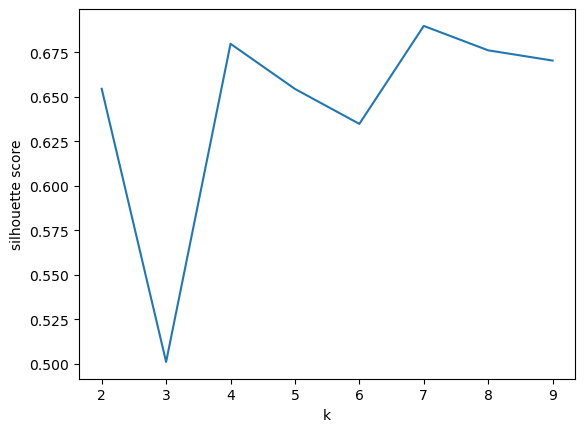

In [73]:
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')

plt.show()

Choosing k = 7 as per the silhouette score.

In [75]:
kmeans = KMeans(featuresCol="AllFeatures", k = 7)
model_kmeans = kmeans.fit(output)

In [76]:
predictions = model_kmeans.transform(output)

In [196]:
predictions.show(3)

+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+---------------+---+--------------+-------------------+--------------------+----------+
| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|DaysSinceJoined|Age|EducationIndex|Marital_StatusIndex|         AllFeatures|prediction|
+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-------

#### Count of the various predicted Clusters

In [197]:
predictions.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  494|
|         6|  526|
|         3|  381|
|         5|    7|
|         4|  314|
|         2|    1|
|         0|  490|
+----------+-----+



In [111]:
temp = predictions.drop('EducationIndex', 'Marital_StatusIndex', 'AllFeatures')
temp.columns

['Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response',
 'DaysSinceJoined',
 'Age',
 'prediction']

In [112]:
temp.show()

+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+---------------+---+----------+
| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|DaysSinceJoined|Age|prediction|
+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+---

In [115]:
# Save the DataFrame as a CSV file
# temp.write.options(header=True).csv("predsKNN")

In [114]:
temp.toPandas().to_csv("predsKNN.csv")

### Performing Classification 

Based on the number of deals purchased by the customer and whether the customer accepted the offer of the first 5 campaigns, they accept the final campaign offer or not. 

In [159]:
campaign_df = df_1.drop("Education", 'Marital_Status')

In [165]:
campaign_df.columns

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response',
 'DaysSinceJoined',
 'Age',
 'EducationIndex',
 'Marital_StatusIndex']

In [161]:
campaign_df.show(1)

+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+---------------+---+--------------+-------------------+
| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|DaysSinceJoined|Age|EducationIndex|Marital_StatusIndex|
+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+-------

In [166]:
campaign_assembler = VectorAssembler(inputCols = ['Income','Kidhome', 'Teenhome', 'Recency', 'MntWines',
 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases',
 'NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','AcceptedCmp3','AcceptedCmp4',
 'AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Complain','Z_CostContact','Z_Revenue','DaysSinceJoined','Age',
 'EducationIndex','Marital_StatusIndex'], outputCol = "Features")

campaign_asm_df = campaign_assembler.transform(campaign_df)

In [168]:
campaign_asm_df.show(2)

+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+---------------+---+--------------+-------------------+--------------------+
| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|DaysSinceJoined|Age|EducationIndex|Marital_StatusIndex|            Features|
+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+----

Creating a new dataframe with just the features and the target variable.

In [169]:
model_reg_df = campaign_asm_df.select("Features", "Response")

In [171]:
model_reg_df.show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------+--------+
|Features                                                                                                                        |Response|
+--------------------------------------------------------------------------------------------------------------------------------+--------+
|[58138.0,0.0,0.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,8.0,10.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,849.0,58.0,0.0,2.0]|1       |
|[46344.0,1.0,1.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,299.0,61.0,0.0,2.0]         |0       |
|[71613.0,0.0,0.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,498.0,50.0,0.0,1.0]|0       |
|[26646.0,1.0,0.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,325.0,31.0,0.0,1.0]       |0       |
|[58293.0,1.0,0.0,94

Creating the train, test split

In [172]:
training_df, test_df = model_reg_df.randomSplit([0.7, 0.3])

In [173]:
training_df.count(), test_df.count()

(1578, 635)

In [174]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(labelCol = 'Response', featuresCol="Features", numTrees=100).fit(training_df)

In [175]:
rf_predictions = rf_classifier.transform(test_df)

In [181]:
rf_predictions.show()

+--------------------+--------+--------------------+--------------------+----------+
|            Features|Response|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(27,[0,1,2,3,4,6,...|       0|[90.6731489514981...|[0.90673148951498...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[94.8316357501522...|[0.94831635750152...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[94.8316357501522...|[0.94831635750152...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[91.0509901182429...|[0.91050990118242...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[95.0991784911895...|[0.95099178491189...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[91.7508710184763...|[0.91750871018476...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[94.9134726949333...|[0.94913472694933...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[94.8947333959632...|[0.94894733395963...|       0.0|
|(27,[0,1,2,3,4,6,...|       0|[92.6041534081171...|[0.9260415340

### Determining the accuracy of the Predictions 

In [178]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [179]:
rf_auc = BinaryClassificationEvaluator(labelCol = "Response").evaluate(rf_predictions)

In [180]:
rf_auc

0.8545046536438236

AUC score of 0.85 is a good score.

In [184]:
cols = ['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'DaysSinceJoined',
 'Age',
 'EducationIndex',
 'Marital_StatusIndex']
for i, col in enumerate(cols):
    print(f"{i} : {col}")

0 : Income
1 : Kidhome
2 : Teenhome
3 : Recency
4 : MntWines
5 : MntFruits
6 : MntMeatProducts
7 : MntFishProducts
8 : MntSweetProducts
9 : MntGoldProds
10 : NumDealsPurchases
11 : NumWebPurchases
12 : NumCatalogPurchases
13 : NumStorePurchases
14 : NumWebVisitsMonth
15 : AcceptedCmp3
16 : AcceptedCmp4
17 : AcceptedCmp5
18 : AcceptedCmp1
19 : AcceptedCmp2
20 : Complain
21 : Z_CostContact
22 : Z_Revenue
23 : DaysSinceJoined
24 : Age
25 : EducationIndex
26 : Marital_StatusIndex


In [182]:
rf_classifier.featureImportances

SparseVector(27, {0: 0.0612, 1: 0.0019, 2: 0.0114, 3: 0.0837, 4: 0.0657, 5: 0.0141, 6: 0.0424, 7: 0.021, 8: 0.0189, 9: 0.0295, 10: 0.0135, 11: 0.0253, 12: 0.037, 13: 0.0242, 14: 0.0338, 15: 0.0953, 16: 0.0091, 17: 0.1524, 18: 0.1031, 19: 0.0052, 20: 0.0009, 23: 0.0682, 24: 0.035, 25: 0.0149, 26: 0.0324})

- It can be seen that the feature 17 and 18 (AcceptedCmp5 and AcceptedCmp1) are the most important features. 15% and 10% importance. 

- Followed by featuer 15 (AcceptedCmp3) with 9.5% importance. 